In [1]:
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import math
import sh

IOSTAT_COLUMNS = ['Device:', 'rrqm/s', 'wrqm/s', 'r/s', 'w/s', 'rkB/s', 'wkB/s', 'avgrq-sz', 'avgqu-sz',
                  'await', 'r_await', 'w_await', 'svctm', '%util']
TEST_CONFIG = 'fixed-rate-submit'
DISK_CONFIG = 'ssd'

NJOBS = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
NDISKS = [1, 2, 4, 8]

DISKS = ['sdb', 'sdc', 'sdd', 'sde', 'sdf', 'sdg', 'sdh', 'sdi']

seaborn.set()
seaborn.set_context('talk')

jq = sh.jq.bake('-M', '-r')

def fio_iops_series(directory):
    iops = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.iops', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        iops.append(float(data.strip()))
    return pd.Series(iops, NJOBS)

def fio_latency_series(directory):
    latency = []
    for njobs in NJOBS:
        data = jq('.jobs[0].write.lat_ns.mean', '{:s}/fio-{:d}-jobs/fio.json'.format(directory, njobs))
        latency.append(float(data.strip()))
    return pd.Series(latency, NJOBS)

def iostat_column_series(column, directory, ndisks):
    jobavgs = []
    for njobs in NJOBS:
        diskavgs = pd.Series()
        for disk in DISKS[0:ndisks]:
            data = pd.read_csv('{:s}/fio-{:d}-jobs/iostat-{:s}.txt'.format(directory, njobs, disk),
                               delim_whitespace=True, header=None, names=IOSTAT_COLUMNS, skiprows=5)
            diskavgs[disk] = data[column].mean()
        jobavgs.append(data[column].mean())
    return pd.Series(jobavgs, NJOBS)

def get_pctchange_dataframe(project, master):
    diff = pd.DataFrame()
    for plabel, mlabel in zip(project, master):
        new = project[plabel]
        old = master[mlabel]
        diff[plabel.replace('project - ', '')] = 100 * ((new - old) / old)
    return diff

def plot_iops_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- write iops vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('write iops reported by fio')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_latency_dataframe(df):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('fio -- average write latency vs. fio threads')
    plt.xlabel('number of fio threads issuing writes')
    plt.ylabel('average write latency reported by fio (microseconds)')
    plt.loglog(basey=2)
    plt.xticks(df.index, df.index)
    plt.show()

def plot_iostat_column_dataframe(df, column):
    df.plot(figsize=(16, 9), style='-o')
    plt.title('iostat -- {:s} vs. fio threads'.format(column))
    plt.xlabel('number of fio threads issuing writes')
    plt.xscale('log')
    plt.xticks(df.index, df.index)
    plt.show()

In [2]:
master_latency = pd.DataFrame()
master_iops = pd.DataFrame()
master_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/master/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'master - {:d} {:s}'.format(i, DISK_CONFIG)
    master_latency[label] = fio_latency_series(directory)
    master_iops[label] = fio_iops_series(directory)
    master_busy[label] = iostat_column_series('%util', directory, i)

project_latency = pd.DataFrame()
project_iops = pd.DataFrame()
project_busy = pd.DataFrame()
for i in NDISKS:
    directory = 'zfsonlinux-6566-perf/{:s}/project/{:d}-{:s}'.format(TEST_CONFIG, i, DISK_CONFIG)
    label = 'project - {:d} {:s}'.format(i, DISK_CONFIG)
    project_latency[label] = fio_latency_series(directory)
    project_iops[label] = fio_iops_series(directory)
    project_busy[label] = iostat_column_series('%util', directory, i)

pctchange_latency = get_pctchange_dataframe(project_latency, master_latency)
pctchange_iops = get_pctchange_dataframe(project_iops, master_iops)

# ZFS on Linux #6566 Performance Results - Fixed Rate Submit on SSDs

### Workload Details

This workload consisted of using `fio` to drive synchronous writes, while varying the number of threads used by `fio`. Each `fio` thread would issue writes to a unique file, using sequential file offsets, `pwrite`, `O_SYNC`, a blocksize of `8k`, and a queue depth of 1 (i.e. each thread performing a single write at a time). Additionally, each thread would attempt to acheive a bandwidth of about 64 writes per second; i.e. after a write completes, the thread may artficially delay, such that it doesn't exceed its target of 64 write operations per second. Here's the `fio` configuration used to acheive this:
```
[global]
group_reporting
clocksource=cpu
ioengine=psync
fallocate=none
blocksize=8k
runtime=60
time_based
iodepth=1
rw=write
thread=0
direct=0
sync=1

# Real world random request flow follows Poisson process. To give better
# insight on latency distribution, we simulate request flow under Poisson
# process.
rate_process=poisson
rate_iops=64

[zfs-workload]
```

The command line flag `--numjobs` was used to vary the number of threads used for each invocation, ranging from a single thread to 1024 threads.

### ZFS Pool and Dataset Configuration

The above `fio` workload was run on zpools with varying numbers of direct attached disks; configurations of 1 disk, 2 disks, 4 disks, and 8 disks were used. All configuration options were kept default at the zpool level (i.e. no `-o` options were passed to `zpool create`).

For all tests, a single ZFS dataset was used to store all the `fio` files for all thread counts. The configuration options used for this dataset were the following: `recsize=8k`, `compress=lz4`, `checksum=edonr`, `redundant_metadata=most`. These were all chosen to match the options used by our Delphix Engine, except `recsize`, which was used to avoid the read-modify-write penalty since `fio` was issuing `8k` writes.

### System Hardware Configuration
 
 - VM running on VMWare ESXi 6.0.0
 - 32 vCPUs
 - 512 GB of RAM
 - Enterprise Solid State Disks

## IOPs as reported by `fio` vs. number of `fio` threads

Below are graphs of the write IOPs reported by `fio` (using the `write.iops` metric), which accounts for all `fio` threads in the given run; i.e. it's the aggregate value for all `fio` threads vs. the value of each individual `fio` thread. Additionally, each line corresponds to a different zpool configuration; each configuration having a different number of disks in the pool.

### IOPs as reported by `fio` vs. number of `fio` threads - master branch

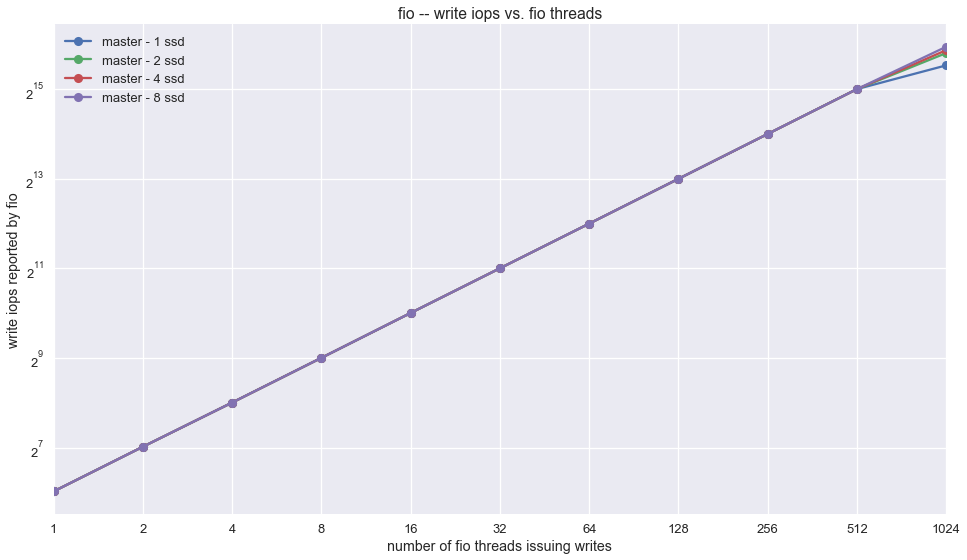

In [3]:
plot_iops_dataframe(master_iops)

In [4]:
master_iops

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,65.108764,65.108764,65.108764,65.108764
2,129.934375,129.934375,129.934375,129.934375
4,257.353676,257.353676,257.337020,257.353676
8,513.840773,513.840773,513.840773,513.824117
16,1028.876898,1028.793152,1028.876898,1028.876898
32,2053.124167,2053.124167,2053.124167,2053.124167
64,4096.298515,4096.298515,4096.298515,4096.298515
128,8189.584582,8189.584582,8189.584582,8189.584582
256,16397.510152,16397.476866,16397.443579,16397.443579
512,32804.067097,32806.273922,32806.307206,32802.845731


### IOPs as reported by `fio` vs. number of `fio` threads - project branch

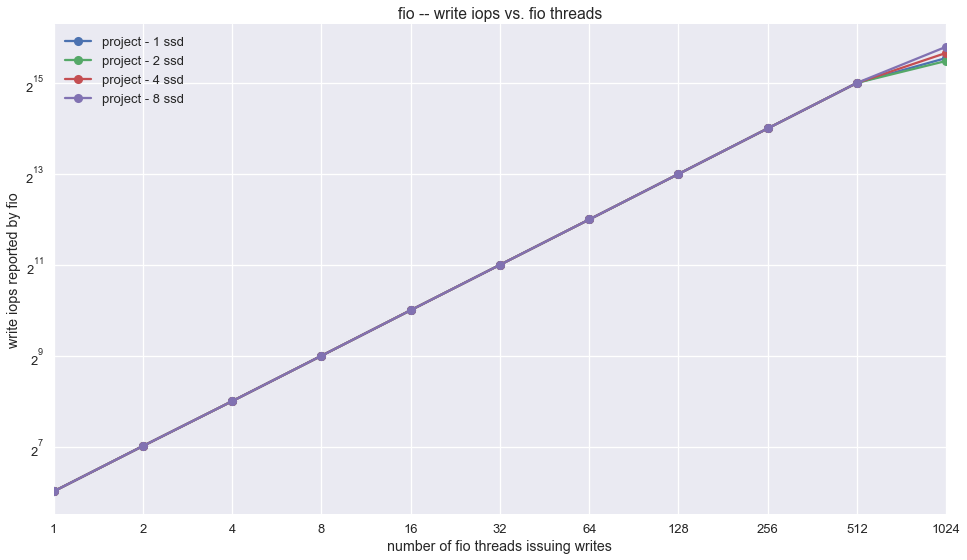

In [5]:
plot_iops_dataframe(project_iops)

In [6]:
project_iops

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,65.108764,65.108764,65.108764,65.108764
2,129.934375,129.934375,129.934375,129.934375
4,257.353676,257.353676,257.353676,257.353676
8,513.840773,513.840773,513.840773,513.824117
16,1028.859765,1028.876898,1028.876898,1028.793632
32,2053.124167,2053.124167,2053.124167,2053.124167
64,4096.298515,4096.298515,4096.298515,4096.298515
128,8189.567938,8189.584582,8189.584582,8189.584582
256,16400.476103,16397.526796,16397.526796,16397.526796
512,32806.040939,32806.357131,32803.078715,32806.390414


## % change in write IOPs vs. number of `fio` threads - master vs. project

The following graph shows the percentage change for the IOPs reported by `fio`, between the "master" and "project" test runs. A positive value here reflects an increase in the IOPs reported by fio when comparing the results of the "project" branch to the "master" branch; i.e. positive is better. Additionally, a 100% increase would reflect a doubling of the IOPs. Similarly, a 50% decrease would equate to halving the IOPs.

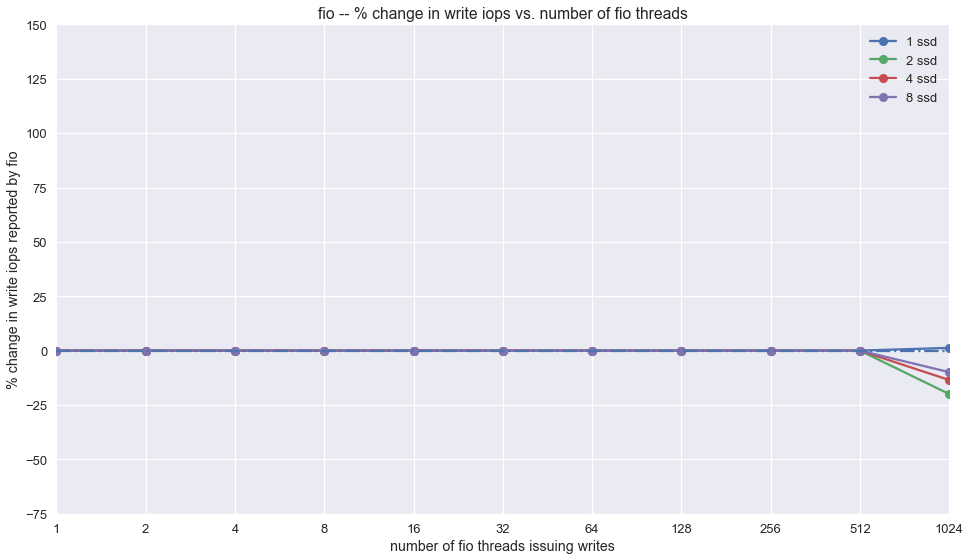

In [7]:
pctchange_iops.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in write iops vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in write iops reported by fio')
plt.ylim(-75, 150)
plt.xscale('log')
plt.xticks(pctchange_iops.index, pctchange_iops.index)
plt.axhline(0, ls='-.')
plt.show()

In [8]:
pctchange_iops

,1 ssd,2 ssd,4 ssd,8 ssd
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.006472,0.000000
8,0.000000,0.000000,0.000000,0.000000
16,-0.001665,0.008140,0.000000,-0.008093
32,0.000000,0.000000,0.000000,0.000000
64,0.000000,0.000000,0.000000,0.000000
128,-0.000203,0.000000,0.000000,0.000000
256,0.018088,0.000304,0.000507,0.000507
512,0.006017,0.000254,-0.009841,0.010806


## average write latency as reported by `fio` vs. number of `fio` threads

Below are graphs of the average write latency (in microseconds) reported by `fio` (using the `write.lat.mean` metric), for all `fio` threads in the test run. Just like the graph of IOPs above, each line represents a different zpool configuration, and there's data for the "master" branch as well as the "project" branch.

## average write latency as reported by `fio` vs. number of `fio` threads - maser branch

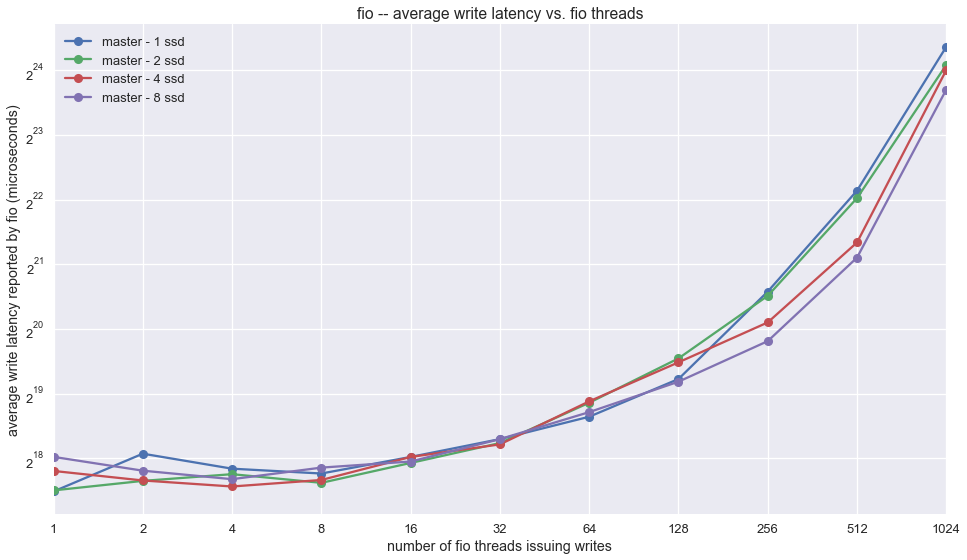

In [9]:
plot_latency_dataframe(master_latency)

In [10]:
master_latency

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,1.840855e+05,1.861903e+05,2.293288e+05,2.666411e+05
2,2.759050e+05,2.061441e+05,2.070840e+05,2.299862e+05
4,2.349546e+05,2.215424e+05,1.941495e+05,2.099849e+05
8,2.231026e+05,2.019021e+05,2.081641e+05,2.376654e+05
16,2.664638e+05,2.498411e+05,2.664396e+05,2.537072e+05
32,3.225429e+05,3.092213e+05,3.047890e+05,3.224427e+05
64,4.098796e+05,4.761059e+05,4.832982e+05,4.306121e+05
128,6.138707e+05,7.655668e+05,7.340713e+05,5.966268e+05
256,1.566698e+06,1.496859e+06,1.125673e+06,9.212196e+05
512,4.618123e+06,4.263136e+06,2.650567e+06,2.253601e+06


### average write latency as reported by `fio` vs. number of `fio` threads - project branch

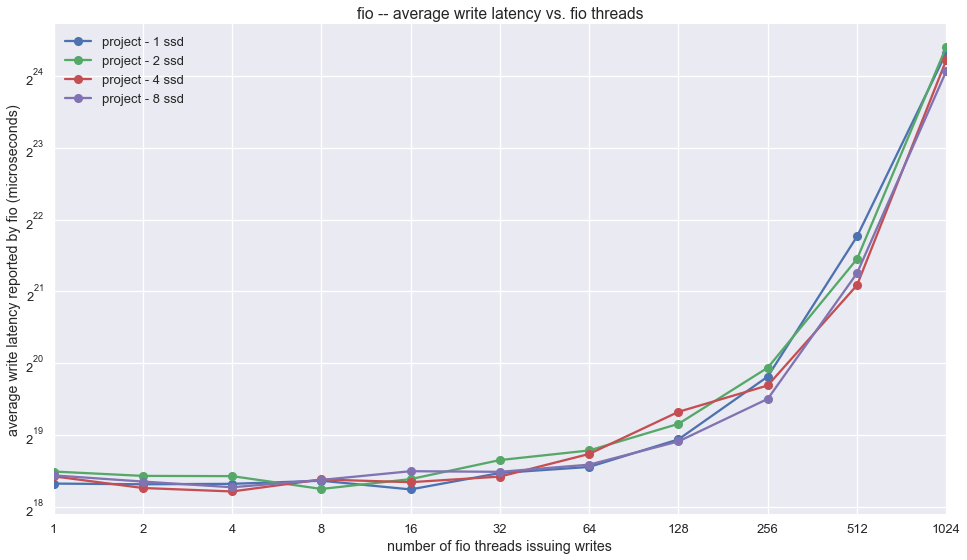

In [11]:
plot_latency_dataframe(project_latency)

In [12]:
project_latency

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,3.272342e+05,3.677324e+05,3.510393e+05,3.542447e+05
2,3.250831e+05,3.524665e+05,3.135654e+05,3.337092e+05
4,3.264772e+05,3.516648e+05,3.032600e+05,3.158423e+05
8,3.363377e+05,3.106888e+05,3.404672e+05,3.389576e+05
16,3.092877e+05,3.416537e+05,3.317053e+05,3.688062e+05
32,3.623704e+05,4.107328e+05,3.500578e+05,3.665954e+05
64,3.843278e+05,4.506265e+05,4.357062e+05,3.928299e+05
128,5.016611e+05,5.827716e+05,6.545003e+05,4.918687e+05
256,9.202222e+05,1.002432e+06,8.444280e+05,7.417223e+05
512,3.560689e+06,2.864118e+06,2.224616e+06,2.498049e+06


## % change in average write latency vs. number of `fio` threads -  master vs. project

The following graph shows the percentage change for the average write latency reported by `fio`, between the "master" branch and "project" branch test runs. A positive value here reflects an increase in the average write latency reported by `fio` when comparing the "project" to the "baseline". Thus, unlike the IOPs numbers above, a negative value here is better.

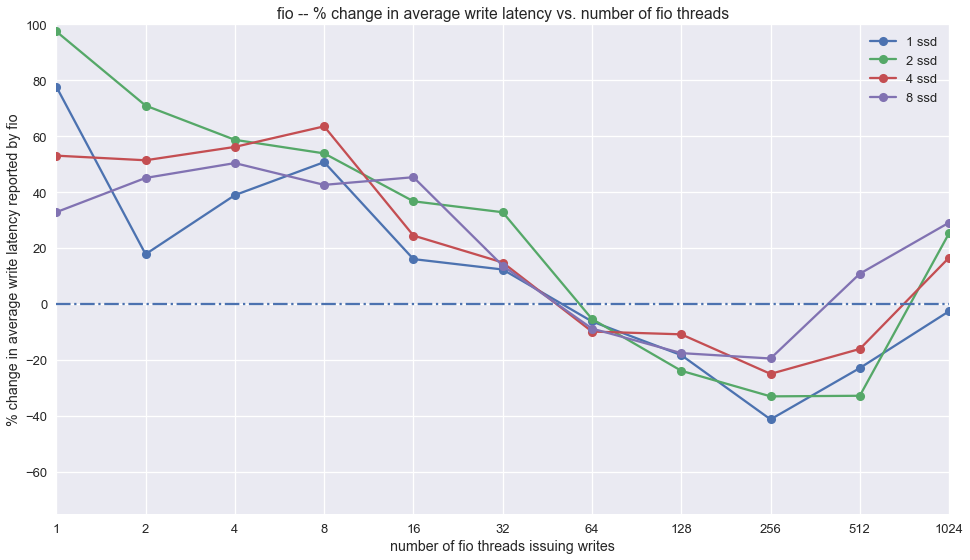

In [13]:
pctchange_latency.plot(figsize=(16, 9), style='-o')
plt.title('fio -- % change in average write latency vs. number of fio threads')
plt.xlabel('number of fio threads issuing writes')
plt.ylabel('% change in average write latency reported by fio')
plt.ylim(-75, 100)
plt.xscale('log')
plt.xticks(pctchange_latency.index, pctchange_latency.index)
plt.axhline(0, ls='-.')
plt.show()

In [14]:
pctchange_latency

,1 ssd,2 ssd,4 ssd,8 ssd
1,77.762112,97.503566,53.072516,32.854481
2,17.824276,70.980664,51.419460,45.099685
4,38.953312,58.734755,56.199233,50.411921
8,50.754690,53.880918,63.557164,42.619682
16,16.071206,36.748405,24.495475,45.366842
32,12.347984,32.828088,14.852518,13.693215
64,-6.233975,-5.351618,-9.847347,-8.774071
128,-18.279024,-23.877100,-10.839685,-17.558389
256,-41.263574,-33.030947,-24.984632,-19.484743
512,-22.897484,-32.816647,-16.070157,10.847006


## `%util` averaged across all disks in zpool vs. `fio` threads

Below are graphs of the `%util` column from `iostat` for all disks in the zpool.

The values that're shown were generating by using 1 second samples (i.e. `iostat -x 1`) for each disk in the zpool, for the entire runtime of the test. These samples were then averaged to acheive a single `%util` average for each disk in the zpool. Then, the single value per disk was averaged across all disks in the zpool, to achieve a single `%util` value, representing all disks in the zpool.

This provides an approximation for how utilized the disks in the zpool were, during the runtime of the `fio` workload.

### `%util` averaged across all disks in zpool vs. `fio` threads - master branch

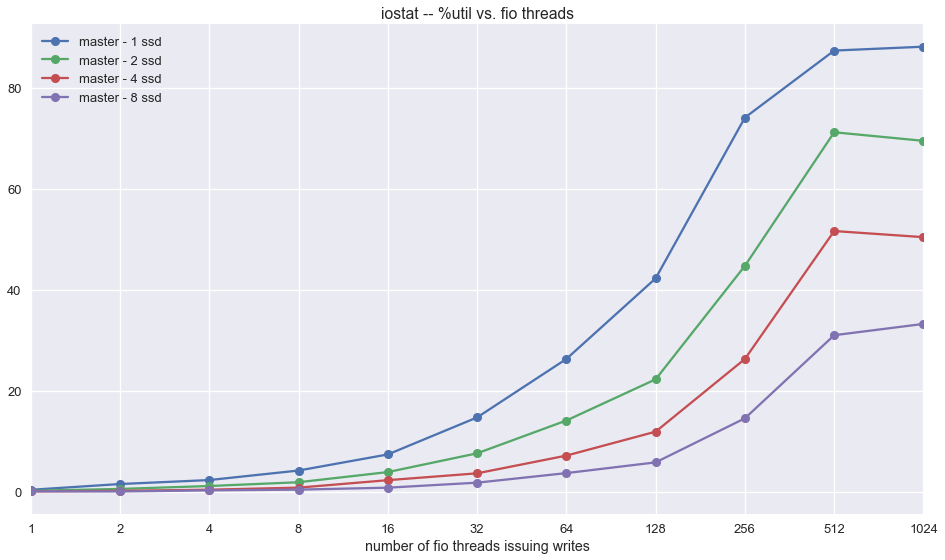

In [15]:
plot_iostat_column_dataframe(master_busy, '%util')

In [16]:
master_busy

,master - 1 ssd,master - 2 ssd,master - 4 ssd,master - 8 ssd
1,0.480000,0.283636,0.167273,0.181818
2,1.621818,0.654545,0.283636,0.152727
4,2.407273,1.228909,0.501818,0.363636
8,4.290909,1.978182,0.909091,0.516364
16,7.474909,3.985455,2.385455,0.901818
32,14.792727,7.694545,3.738182,1.890909
64,26.356364,14.186182,7.243636,3.781818
128,42.298545,22.330364,11.978182,5.905455
256,74.096727,44.778182,26.358182,14.622364
512,87.351636,71.197091,51.659091,31.057091


### `%util` averaged across all disks in zpool vs. `fio` threads - project branch

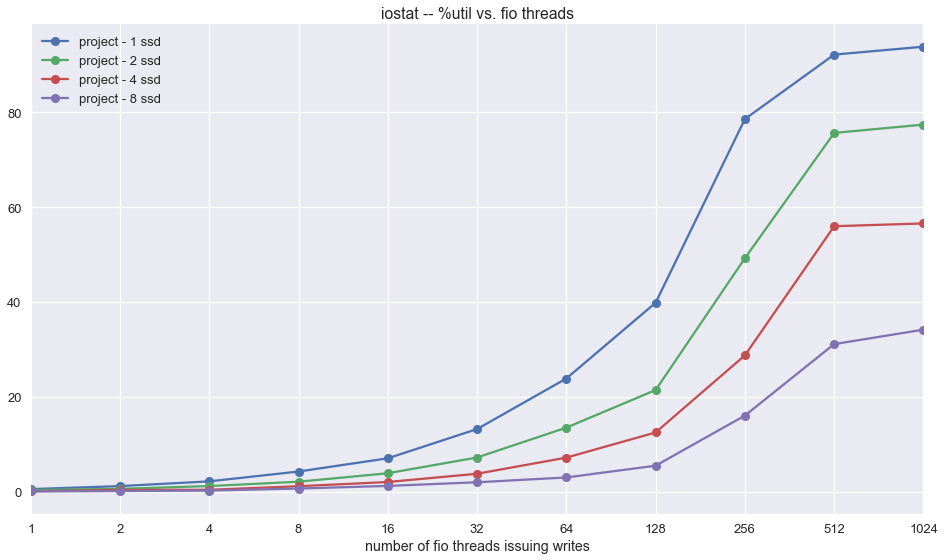

In [17]:
plot_iostat_column_dataframe(project_busy, '%util')

In [18]:
project_busy

,project - 1 ssd,project - 2 ssd,project - 4 ssd,project - 8 ssd
1,0.603636,0.407273,0.145455,0.109091
2,1.236364,0.654545,0.436364,0.196364
4,2.240000,1.250727,0.458182,0.290909
8,4.312727,2.160000,1.214545,0.727273
16,7.096182,3.949091,2.101818,1.280000
32,13.258182,7.265455,3.840000,2.043636
64,23.916182,13.563636,7.242182,3.061818
128,39.890909,21.490909,12.545455,5.541818
256,78.609455,49.277818,28.800000,16.106364
512,92.189091,75.680000,56.018182,31.168545
